In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [27]:
# Load datasets
train = pd.read_csv("/content/drive/MyDrive/train.csv")
test  = pd.read_csv("/content/drive/MyDrive/test.csv")

In [28]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [29]:
train.shape, test.shape


((1460, 81), (1459, 80))

###Separate Target

In [30]:
y = train["SalePrice"]
X = train.drop("SalePrice", axis=1)


###To make price distribution normal - Log Transform SalePrice

In [31]:
y = np.log1p(y)



###Combine Train and Test (combine bcz encoding must be identical otherwise it will not be matched)

In [32]:
all_data = pd.concat([X, test], axis=0)


In [33]:
all_data.isnull().sum()[all_data.isnull().sum() > 0]


,0
MSZoning,4
LotFrontage,486
Alley,2721
Utilities,2
Exterior1st,1
Exterior2nd,1
MasVnrType,1766
MasVnrArea,23
BsmtQual,81
BsmtCond,82


###Fill categorical missing values with "None"

In [34]:
cat_cols = all_data.select_dtypes(include=["object"]).columns
all_data[cat_cols] = all_data[cat_cols].fillna("None")


###Fill LotFrontage with Neighborhood Median

In [35]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)

# fallback if still missing
all_data["LotFrontage"] = all_data["LotFrontage"].fillna(
    all_data["LotFrontage"].median()
)


###Fill GarageYrBlt with median

In [36]:
all_data["GarageYrBlt"] = all_data["GarageYrBlt"].fillna(
    all_data["GarageYrBlt"].median()
)


###Fill TRUE absence features with 0

In [37]:
zero_fill_cols = [
    "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF",
    "GarageArea", "GarageCars",
    "PoolArea"
]

all_data[zero_fill_cols] = all_data[zero_fill_cols].fillna(0)


In [38]:
all_data = all_data.fillna(0)


In [39]:
all_data.isnull().sum()[all_data.isnull().sum() > 0]

,0


###Encode Ordered Quality Features

In [40]:
qual_map = {
    "None": 0,
    "Po": 1,
    "Fa": 2,
    "TA": 3,
    "Gd": 4,
    "Ex": 5
}

qual_features = [
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond",
    "HeatingQC", "KitchenQual", "FireplaceQu",
    "GarageQual", "GarageCond", "PoolQC"
]

for col in qual_features:
    all_data[col] = all_data[col].map(qual_map)


In [41]:
all_data = pd.get_dummies(all_data)


##EDA (Exploratory Data Analysis)

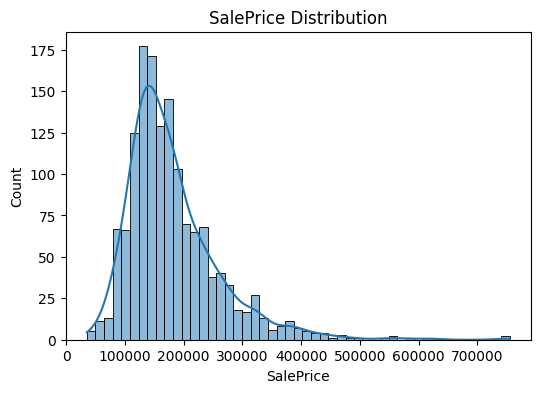

In [23]:
plt.figure(figsize=(6,4))
sns.histplot(train["SalePrice"], kde=True)
plt.title("SalePrice Distribution")
plt.show()


Right-skewed distribution - Few very expensive houses

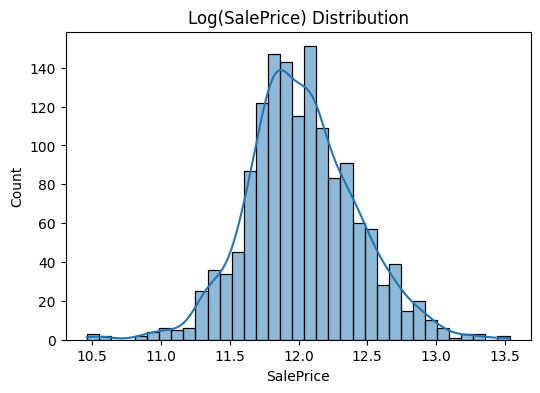

In [24]:
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(train["SalePrice"]), kde=True)
plt.title("Log(SalePrice) Distribution")
plt.show()


Log transformed data

Which numerical features affect price the most?

In [43]:
train_processed_features = all_data.iloc[:len(X)]
train_processed = pd.concat([train_processed_features, y], axis=1)

corr = train_processed.corr()

top_corr = corr["SalePrice"].sort_values(ascending=False)[1:11]
top_corr

,SalePrice
OverallQual,0.817185
GrLivArea,0.700927
GarageCars,0.680625
ExterQual,0.678840
KitchenQual,0.667893
GarageArea,0.650888
BsmtQual,0.615804
TotalBsmtSF,0.612134
1stFlrSF,0.596981
FullBath,0.594771


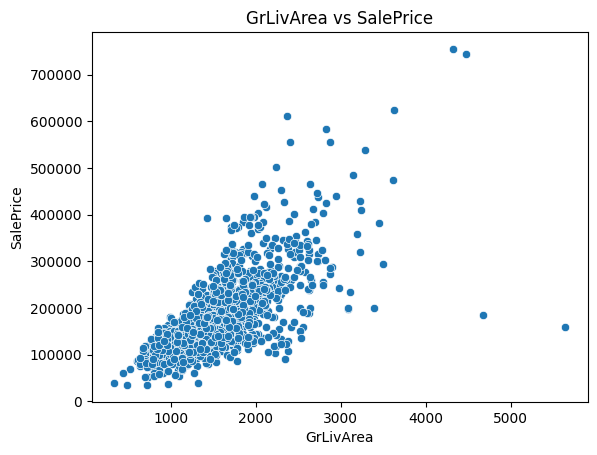

In [44]:
sns.scatterplot(
    x=train["GrLivArea"],
    y=train["SalePrice"]
)
plt.title("GrLivArea vs SalePrice")
plt.show()


Bigger living area ==> Higher Price

categorical impact

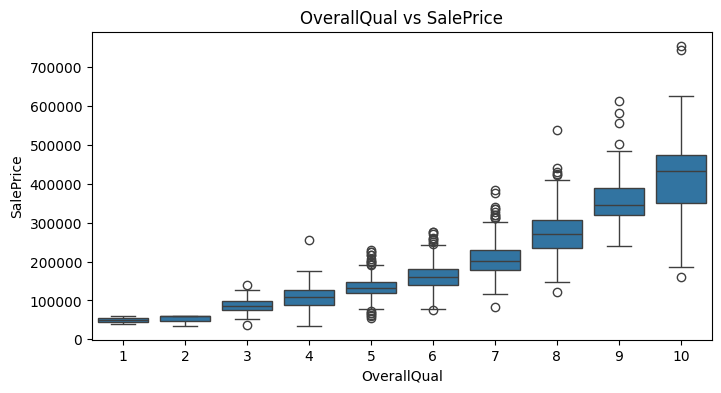

In [45]:
plt.figure(figsize=(8,4))
sns.boxplot(
    x=train["OverallQual"],
    y=train["SalePrice"]
)
plt.title("OverallQual vs SalePrice")
plt.show()


Higher quality → much higher price

Neighborhood effect

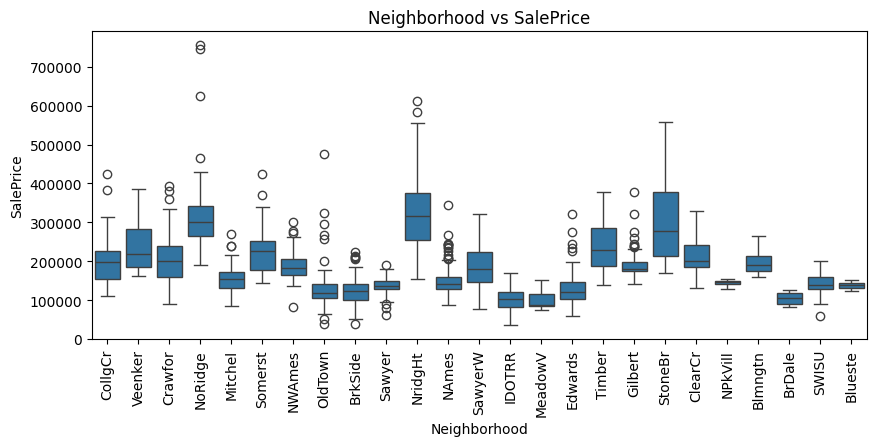

In [46]:
plt.figure(figsize=(10,4))
sns.boxplot(
    x=train["Neighborhood"],
    y=train["SalePrice"]
)
plt.xticks(rotation=90)
plt.title("Neighborhood vs SalePrice")
plt.show()


Drop unnecessary columns

In [50]:
# Save test IDs for submission
test_ids = test["Id"]


In [52]:
cols_to_drop = [
    "Utilities",
    "Street",
    "Alley",
    "Fence",
    "MiscFeature",
    "PoolArea",
    "PoolQC"
]

existing_cols = [col for col in cols_to_drop if col in all_data.columns]

all_data = all_data.drop(columns=existing_cols)


##Split Back Train & Test

In [53]:
X_final = all_data[:len(train)]
X_test_final = all_data[len(train):]


##Baseline Model (Regression)

In [54]:
ridge = Ridge(alpha=10)

rmse = np.sqrt(-cross_val_score(
    ridge, X_final, y,
    scoring="neg_mean_squared_error",
    cv=5
).mean())

rmse


np.float64(0.14188617592505995)

##Random Forest (RF)

In [55]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rmse_rf = np.sqrt(-cross_val_score(
    rf, X_final, y,
    scoring="neg_mean_squared_error",
    cv=5
).mean())

rmse_rf


np.float64(0.1423817508338334)

##Gradient Boosting Regressor (GBR)

In [72]:
gbr = GradientBoostingRegressor(
    n_estimators=3000,
    learning_rate=0.01,
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)

rmse_gbr = np.sqrt(-cross_val_score(
    gbr, X_final, y,
    scoring="neg_mean_squared_error",
    cv=5
).mean())

rmse_gbr


np.float64(0.12374914798488876)

###Train all 3 models

In [74]:
lr = LinearRegression()

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

gbr = GradientBoostingRegressor(
    n_estimators=3000,
    learning_rate=0.01,
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)

lr.fit(X_final, y)
rf.fit(X_final, y)
gbr.fit(X_final, y)


GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_leaf=5,
                          min_samples_split=10, n_estimators=3000,
                          random_state=42, subsample=0.8)

In [75]:
lr_pred  = lr.predict(X_test_final)
rf_pred  = rf.predict(X_test_final)
gbr_pred = gbr.predict(X_test_final)

In [76]:
ensemble_pred = (
    0.2 * lr_pred +
    0.3 * rf_pred +
    0.5 * gbr_pred
)


In [77]:
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": np.expm1(ensemble_pred)
})

submission.to_csv("submission.csv", index=False)


In [78]:
from google.colab import files
files.download("submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>